In [1]:
import os
import argparse
from typing import List
from datetime import datetime
from dataclasses import dataclass
import data
import network
import solver
import joblib
import json
import torch

import matplotlib.pyplot as plt
import numpy as np
import time

In [2]:
def gram_schmidt(N, K):
    """
    Given the dimension space dimension N, generate K random vectors and its orthogonal spans
    """
    
    def proj(u,v):
        """
        Return projection of v to u
        """
        return np.dot(v,u)/np.dot(u,u) * u
    
    V=np.random.normal(loc = 0., scale = 1, size = (K, N))
    U=np.zeros_like(V)
    
    ## Initialise u1 to v1
    U[0] = V[0]
    
    ## Gram-schomidt process
    for k in range(1,K):
        projection_terms = [proj(U[i], V[k]) for i in range(k)]
        U[k] = V[k] - np.sum(projection_terms, axis=0)
    
    return V, U
        

def control_VS(VT, angle):
    dim = len(VT)
    VT_norm = VT/np.linalg.norm(VT)
    c = np.cos(angle)
    a = np.random.normal(loc = 0., scale = 1, size = (dim))
    b = np.random.normal(loc = 0., scale = 1, size = (dim))
    h = (b-a) - np.dot((b-a),VT_norm)*VT_norm
    v = np.cos(angle)*VT_norm + np.sin(angle)*h/np.linalg.norm(h)
    
    return v*0.00001

In [3]:
num_task = 4
seq_len = 2
input_dim = 1000
nums_iter = np.array([0, 200000])
update_frequency = 1000

In [7]:
#for i,vt in enumerate([np.random.normal(0,1, (4)), np.random.normal(0,1, (4)), np.random.normal(0,1, (4)), np.random.normal(0,1, (4))]):
vt = [.1,.1,.1,.1,]
results = {}
noise = 0.1
for lr_v in [0.01]:
    results[lr_v]={}
    for lr_wc in [1]: 
        results[lr_v][lr_wc] = []
        for s in np.arange(1):
            VT_i= np.array(vt)
            VS_i =control_VS(VT_i, np.pi/4)
            _, WT_i =gram_schmidt(input_dim, num_task)
            WS_i = WT_i.copy() + np.random.normal(0, 1, (num_task,input_dim))
            ode_solver_nid = solver.HRLODESolver(VS = VS_i, VT= VT_i, WS=WS_i, WT = WT_i, lr_ws = [1., lr_wc], 
                                                 lr_v=lr_v, seq_length= seq_len, N = input_dim)
            ode_solver_nid.train(nums_iter, update_frequency = update_frequency)
            results[lr_v][lr_wc].append(ode_solver_nid)


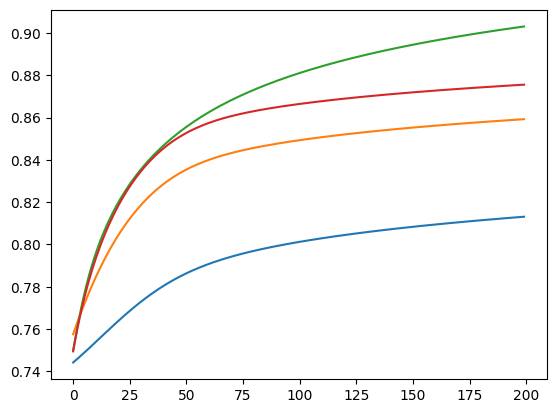

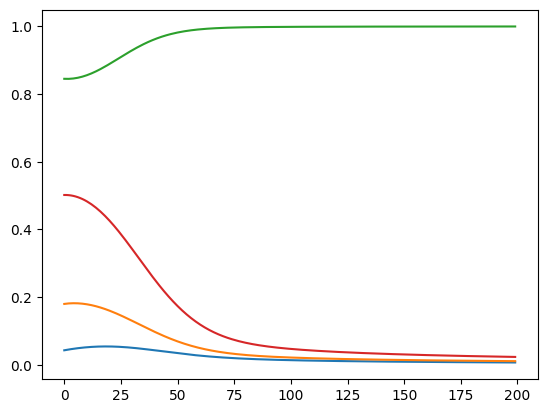

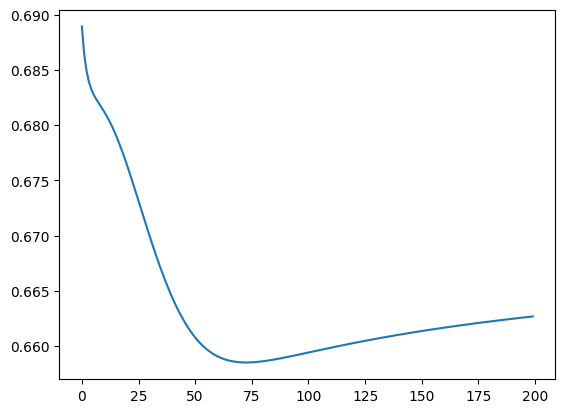

In [8]:
#plt.plot(ode_solver_nid.history['phase2']['VSVT'])
fig = plt.figure()
#for i in range(4):
    #plt.plot(ode_solver_nid.history['phase2']['R'][:,i,i]/np.sqrt(ode_solver_nid.history['phase2']['Q'][:,i,i])/np.sqrt(ode_solver_nid.S[i,i]))
plt.plot(ode_solver_nid.history['phase2']['P'])    
fig = plt.figure()
plt.plot(ode_solver_nid.history['phase2']['VS'])

fig = plt.figure()
plt.plot(ode_solver_nid.history['phase2']['P_tilde'])

In [121]:
ode_solver_nid.history['phase2']['VSVT']

array([0.72496305, 0.99136631, 0.99350837, 0.99425876, 0.99464714,
       0.99488705, 0.99505136, 0.99517188, 0.99526475, 0.99533908,
       0.99540037, 0.99545217, 0.99549687, 0.99553612, 0.99557111,
       0.99560273, 0.99563162, 0.99565829, 0.99568314, 0.99570646,
       0.99572851, 0.99574947, 0.99576949, 0.99578872, 0.99580724,
       0.99582515, 0.99584251, 0.99585938, 0.99587581, 0.99589184,
       0.99590749, 0.9959228 , 0.99593779, 0.99595247, 0.99596686,
       0.99598097, 0.99599482, 0.9960084 , 0.99602173, 0.99603481,
       0.99604765, 0.99606025, 0.99607262, 0.99608475, 0.99609665,
       0.99610832, 0.99611976, 0.99613098, 0.99614197, 0.99615274,
       0.99616329, 0.99617362, 0.99618374, 0.99619363, 0.99620332,
       0.99621279, 0.99622205, 0.9962311 , 0.99623995, 0.9962486 ,
       0.99625704, 0.99626528, 0.99627333, 0.99628119, 0.99628885,
       0.99629632, 0.99630361, 0.99631072, 0.99631765, 0.9963244 ,
       0.99633098, 0.99633739, 0.99634363, 0.99634971, 0.99635

In [ ]:

#for i,vt in enumerate([np.random.normal(0,1, (4)), np.random.normal(0,1, (4)), np.random.normal(0,1, (4)), np.random.normal(0,1, (4))]):
vt = [1.,1.,1.,1.,]
results = {}
noise = 0.1
for lr_v in [0., 0.001, 0.01, 0.1,1]:
    results[lr_v]={}
    for lr_wc in [1]: 
        results[lr_v][lr_wc] = []
        for s in np.arange(1):
            VT_i= np.array(vt)
            VS_i =control_VS(VT_i, np.pi/4)
            _, WT_i =gram_schmidt(input_dim, num_task)

            WS_i = WT_i.copy() + np.random.normal(0, 1, (num_task,input_dim))*noise
            ode_solver_nid = solver.CurriculumCompositionalTaskSimulator(input_dim = input_dim, seq_len = seq_len,
                                                                         num_task= num_task, identical = False,
                                                                         VS = VS_i, VT= VT_i, WS=WS_i, WT = WT_i,)
            ode_solver_nid.train(lr = {'lr_w':1., 'lr_wc':lr_wc, 'lr_vc': lr_v},num_iter= nums_iter, update_frequency = update_frequency)
            results[lr_v][lr_wc].append(ode_solver_nid)


In [112]:
jl.dump(results, 'curriculum_nonorthogonal_1111.jl')

['curriculum_nonorthogonal_1111.jl']

In [98]:
ode_solver_nid.history['phase2']['P_tilde']

array([0.74394078, 0.78526776, 0.81422852, 0.83533415, 0.85130498,
       0.86378609, 0.87380453, 0.88202605, 0.88889813, 0.8947315 ,
       0.89974822, 0.90411105, 0.90794194, 0.91133408, 0.9143599 ,
       0.91707656, 0.91952979, 0.92175661, 0.92378736, 0.9256471 ,
       0.92735674, 0.9289339 , 0.93039349, 0.93174823, 0.93300906,
       0.93418543, 0.93528555, 0.93631658, 0.9372848 , 0.93819574,
       0.93905432, 0.93986487, 0.94063128, 0.94135701, 0.94204516,
       0.94269855, 0.94331968, 0.94391086, 0.94447415, 0.94501143,
       0.94552443, 0.94601471, 0.94648371, 0.94693275, 0.94736304,
       0.94777569, 0.94817173, 0.94855211, 0.9489177 , 0.94926933,
       0.94960775, 0.94993366, 0.95024771, 0.95055051, 0.95084263,
       0.9511246 , 0.95139692, 0.95166004, 0.95191441, 0.95216044,
       0.9523985 , 0.95262896, 0.95285216, 0.95306841, 0.95327802,
       0.95348127, 0.95367843, 0.95386976, 0.95405549, 0.95423585,
       0.95441105, 0.9545813 , 0.9547468 , 0.95490772, 0.95506

In [63]:
a=[]
b=[]
for i in range(100):
    x = np.random.normal(loc=0.0, scale=1.0, size=(4, 1000, 4))

    (y, y_sign, y_hat,
         y_hat_sign), (y_tilde, y_tilde_hat, y_tilde_sign,
                       y_tilde_hat_sign) = ode_solver_nid.inference(x)

    a.append(y_sign == y_hat_sign)
    b.append(y_tilde_sign == y_tilde_hat_sign)

mse = np.mean(a)
p_empirical = np.mean(b)

In [66]:
np.array(a).mean(0)

array([[0.57, 0.7 , 0.67, 0.6 ],
       [0.58, 0.6 , 0.53, 0.52],
       [0.6 , 0.52, 0.54, 0.58],
       [0.62, 0.7 , 0.65, 0.64]])

In [62]:
y_hat_sign

array([[ 1., -1., -1.,  1.],
       [-1.,  1.,  1.,  1.],
       [ 1., -1., -1.,  1.],
       [ 1.,  1., -1.,  1.]])

In [85]:
import joblib as jl
jl.dump(results, 'curriculum_stability_1111_vsmallv.jl')

['curriculum_stability_1111_vsmallv.jl']

In [100]:
results = jl.load('curriculum_stability_1111_vsmallv.jl')

In [105]:
results[0.01][0.001][0].VS

array([1.52468123, 1.50578927, 1.42769518, 1.71749063])

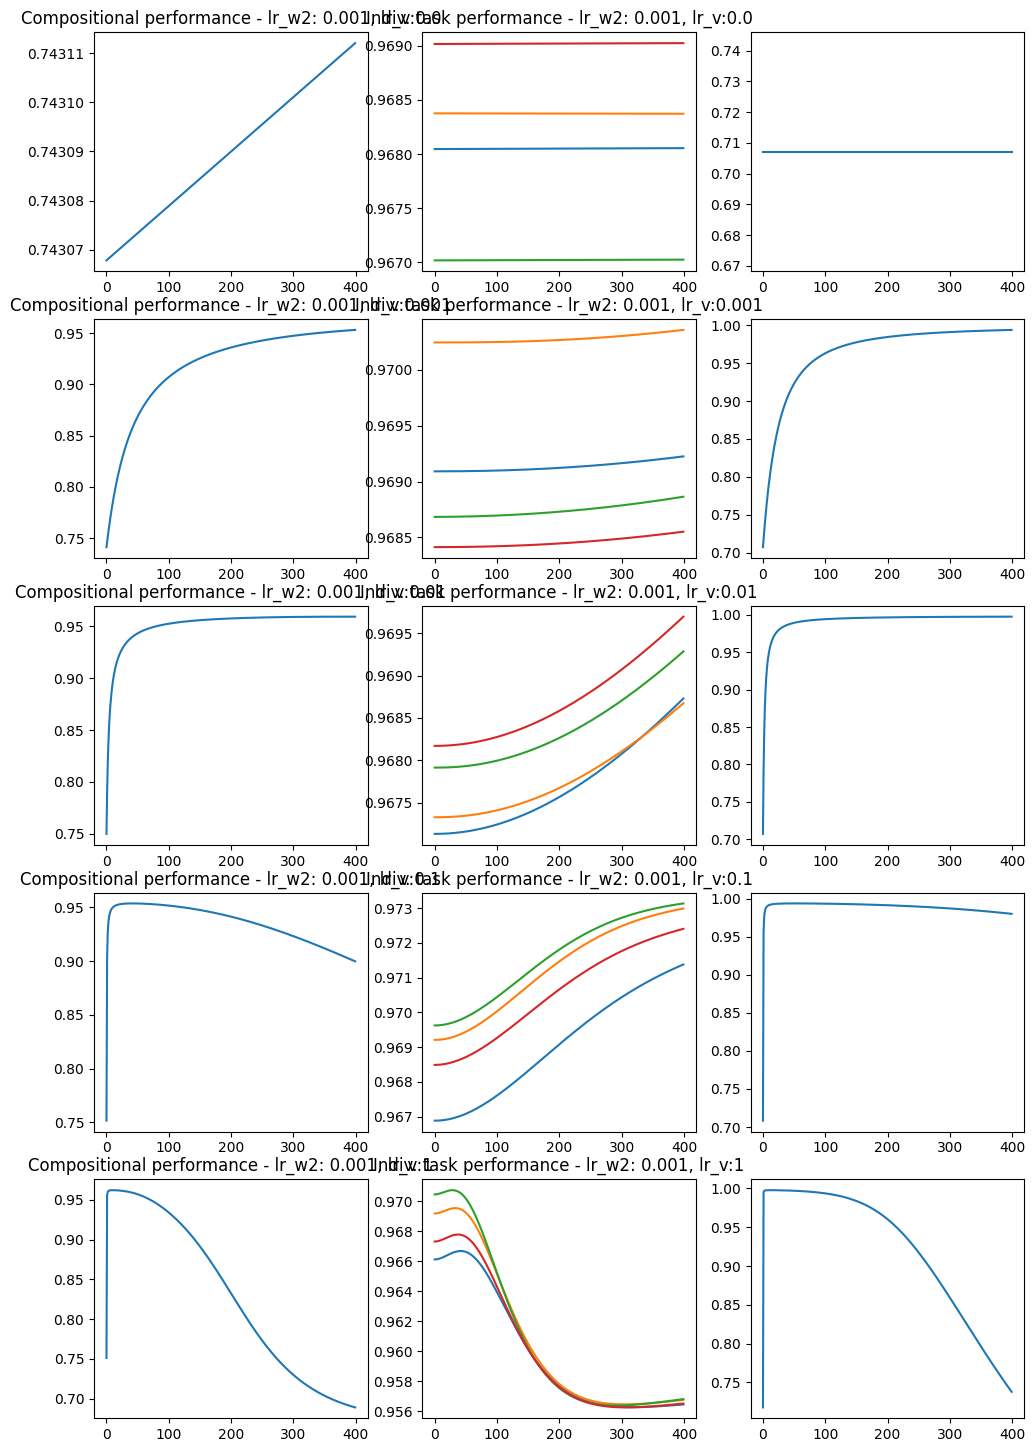

In [113]:
lr_w= 0.001
fig, axs=plt.subplots(nrows = 5,ncols=3, figsize= (12,18))
for j, lr_v in enumerate([0., 0.001, 0.01, 0.1,1]): 
    axs[j][0].plot(np.array([r.history['phase2']['P_tilde'] for r in results[lr_v][lr_w]])[0].T)
    axs[j][1].plot(results[lr_v][lr_w][0].history['phase2']['P'])
    axs[j][2].plot(results[lr_v][lr_w][0].history['phase2']['VSVT'])
    axs[j][0].set_title(f'Compositional performance - lr_w2: {lr_w}, lr_v:{lr_v}')
    axs[j][1].set_title(f'Indiv. task performance - lr_w2: {lr_w}, lr_v:{lr_v}')

In [ ]:
def gather_results(rootdir, identical):
    args = json.load(open(os.path.join(rootdir, 'args.json'), 'r'))
    ps = []
    pts= []
    if identical:
        identical_flag = 'id'
    else:
        identical_flag = 'nid'
    for path in glob.glob( rootdir+'/ode*'):
        ode=jl.load(path)
        p=ode[identical_flag]['phase2']['P']
        p_tilde=ode[identical_flag]['phase2']['P_tilde']
        vs=ode[identical_flag]['phase2']['VS'][0]
        #vt=ode[identical_flag]['VT']
        ps.append(p)
        pts.append(p_tilde)
        
    return np.array(ps), np.array(pts), args
        

In [ ]:
jl

hrl_ode_logs/230823_VTVS_noise/20230823195224.303622/
hrl_ode_logs/230823_VTVS_noise/20230823195224.303695/
hrl_ode_logs/230823_VTVS_noise/20230823195224.303676/
hrl_ode_logs/230823_VTVS_noise/20230823195224.303833/


/nfs/nhome/live/jlee/.conda/envs/composite_learning/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:k'` for same effect.
  warnings.warn(msg, FutureWarning)


hrl_ode_logs/230823_VTVS_noise/20230823195231.658186/
hrl_ode_logs/230823_VTVS_noise/20230823195231.658351/
hrl_ode_logs/230823_VTVS_noise/20230823195231.658131/
hrl_ode_logs/230823_VTVS_noise/20230823195231.658452/


/nfs/nhome/live/jlee/.conda/envs/composite_learning/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:k'` for same effect.
  warnings.warn(msg, FutureWarning)


hrl_ode_logs/230823_VTVS_noise/20230823195231.660193/
hrl_ode_logs/230823_VTVS_noise/20230823195231.660173/
hrl_ode_logs/230823_VTVS_noise/20230823195231.660146/
hrl_ode_logs/230823_VTVS_noise/20230823195231.660841/


/nfs/nhome/live/jlee/.conda/envs/composite_learning/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:k'` for same effect.
  warnings.warn(msg, FutureWarning)


hrl_ode_logs/230823_VTVS_noise/20230823195215.617745/
hrl_ode_logs/230823_VTVS_noise/20230823195224.055229/


/nfs/nhome/live/jlee/.conda/envs/composite_learning/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:k'` for same effect.
  warnings.warn(msg, FutureWarning)


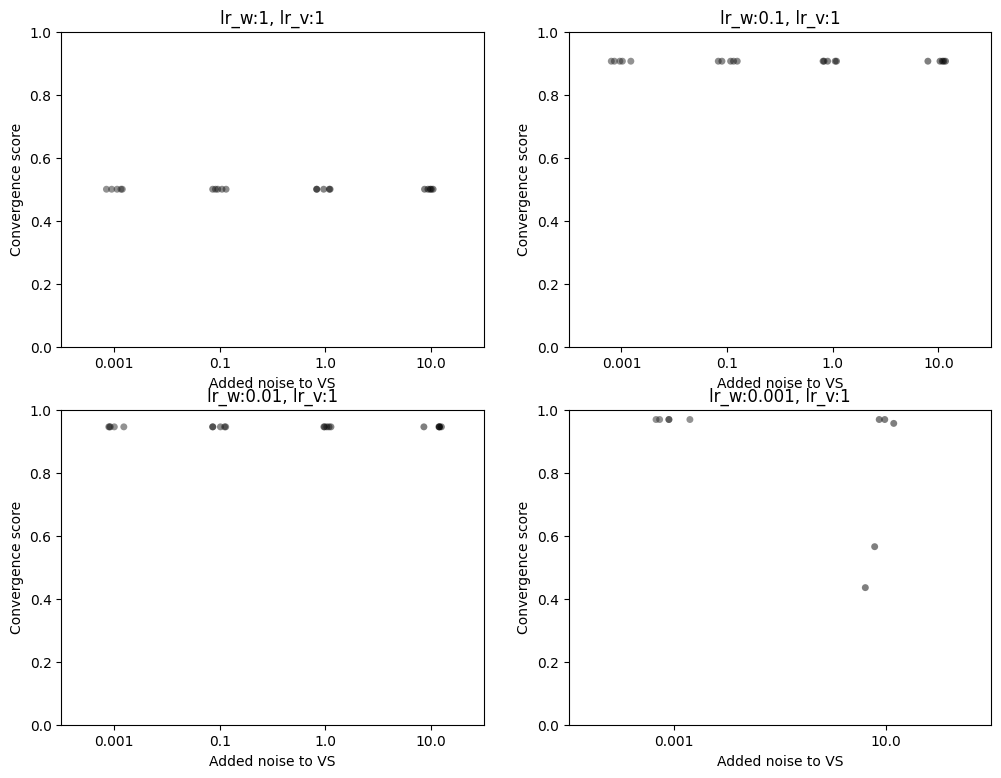

In [207]:
import glob
import joblib as jl
rootdirs=glob.glob('hrl_ode_logs/230823_VTVS_noise/*/')
lr_v = 1
fig, axs = plt.subplots(2,2, figsize=(12,9))
for i,lr_w in enumerate([1, 0.1, 0.01, 0.001]):
    res = {}
    for _, noise in enumerate([0.001,0.1, 1, 10]):
        for rootdir in rootdirs:
            ps, pts, args=gather_results(rootdir, identical = True)
            if args['lr_ws'] ==[0, lr_w] and args['lr_v'] ==lr_v and args['noise_scale']==noise:
                print(rootdir)
                res[noise]= pts[:,-1]

    ax = axs[i//2][i%2]
    sns.stripplot(res, ax = axs[i//2][i%2], color = 'k', alpha = 0.5)
    ax.set_title(f'lr_w:{lr_w}, lr_v:{lr_v}')
    ax.set_xlabel('Added noise to VS')
    ax.set_ylabel('Convergence score')
    ax.set_ylim([0,1])

        
        
        
    

In [212]:
pt=jl.load('hrl_ode_logs/230823_VTVS_noise/20230823195231.658186/ode_1.jl')['id']['phase2']['P_tilde']
p=jl.load('hrl_ode_logs/230823_VTVS_noise/20230823195231.658186/ode_1.jl')['id']['phase2']['P']

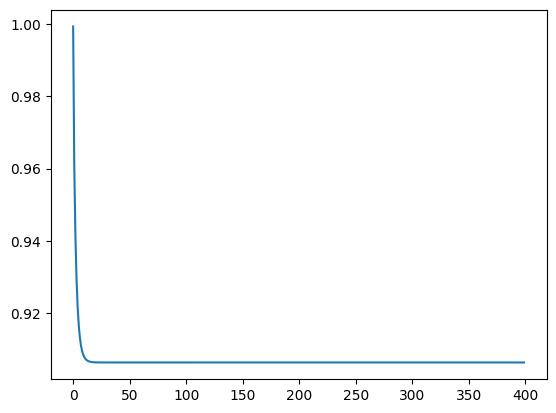

In [213]:
plt.plot(pt.T)

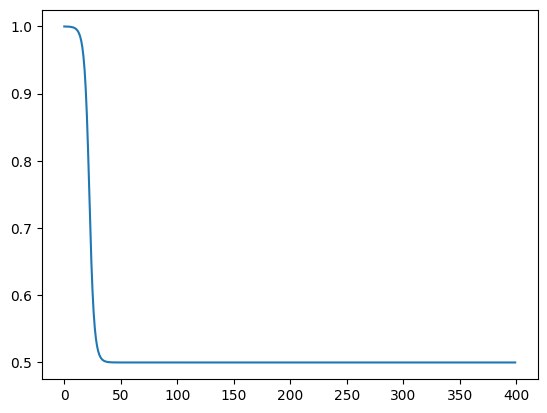

In [224]:
plt.plot(p.T[3])